# Unfolding with different encodings
Show how different encodings affect the result when performing the annealing

In [33]:
import uproot
import boost_histogram as bh
import matplotlib.pyplot as plt
import awkward as ak
import pickle
import numpy as np

In [34]:
def get_config(is_jaguar=True):
    """
        histograms_path = Set the path to store the histograms
        response_matrix_path = Set the path to read the response matrix
    """
    # histograms configuration
    config = {
        "hist" : {
            "nbins" : 50,
            "rmin" : 0.2,
            "rmax" : 1.8
        }
    }
    if is_jaguar:
        print("Loading configuration to run in Jaguar")
        config["data"] = {
            "files" : "/storage/cpegueros/tau2pipi0_taupair_1623721564_00/sub00/data40/*.root",
            "workers" : 45,
            "step_size" : "500 MB"
        }
        config["histograms_path"] = "/home/cpegueros/tau2pipi0nu_for_encoding.pkl"
        config["response_matrix_path"] = "/home/cpegueros/thesis/tau2pipi0nu_response_matrix.pkl"
    else:
        print("Loading configuration to run in local. No data will be available.")
        config["data"] = {
            "files" : None,
            "workers" : None,
            "step_size" : None
        }
        config["histograms_path"] = "/home/peguerosdc/development/thesis/data/tau2pipi0nu_for_encoding.pkl"
        config["response_matrix_path"] = "/home/peguerosdc/development/thesis/data/tau2pipi0nu_response_matrix.pkl"
    return config

## Load the data
Load the data and build the histograms

In [9]:
config = get_config(is_jaguar=True)

Loading configuration to run in Jaguar


In [4]:
# Amount of bins and histogram limits
nbins, rmin, rmax = config["hist"]["nbins"], config["hist"]["rmin"], config["hist"]["rmax"]

# To store the mass of the signal and the background
signal = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
background = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))

In [5]:
# variables to load from the data
branches_to_train = ["thrust","visibleEnergyOfEventCMS","track_sig_EoverP","track_sig_pionID","track_sig_pt", "sig_gamma1_E","sig_gamma2_E","track_sig_cosToThrustOfEvent","neutral_sig_E","neutral_sig_M"]
branches_to_cut = ["nPi0s_sig"]
branch_of_interest = ["tau_sig_InvM", "tau_sig_matchedMC_InvM"]
branches_mc = ["track_sig_charge", "tauPlusMCMode", "tauMinusMCMode"]
branches_to_load = branches_to_train + branches_to_cut + branch_of_interest + branches_mc

for df in uproot.iterate(f"{config['data']['files']}:tau1x1", filter_name=branches_to_load, step_size=config["data"]["step_size"], num_workers=config["data"]["workers"]):
    # filter events with one pi0
    one_pi0_pd = ak.to_pandas(df[ (df.nPi0s_sig == 1) ])
    # split into signal and background
    one_pi0_signal = one_pi0_pd[( ( 
        ( (one_pi0_pd.track_sig_charge==1)  & (one_pi0_pd.tauPlusMCMode ==4) ) | 
        ( (one_pi0_pd.track_sig_charge==-1) & (one_pi0_pd.tauMinusMCMode==4) )
    ) == 1 )]
    signal.fill(one_pi0_signal.tau_sig_matchedMC_InvM)
    one_pi0_background = one_pi0_pd[( ( 
        ( (one_pi0_pd.track_sig_charge==1)  & (one_pi0_pd.tauPlusMCMode ==4) ) | 
        ( (one_pi0_pd.track_sig_charge==-1) & (one_pi0_pd.tauMinusMCMode==4) )
    ) == 0 )]
    background.fill(one_pi0_background.tau_sig_matchedMC_InvM)

# Save a tuple containing these two histograms in a Pickle file
with open(config["histograms_path"], 'wb') as output:
    temp = {
        "signal" : signal,
        "background" : background,
    }
    pickle.dump(temp, output)

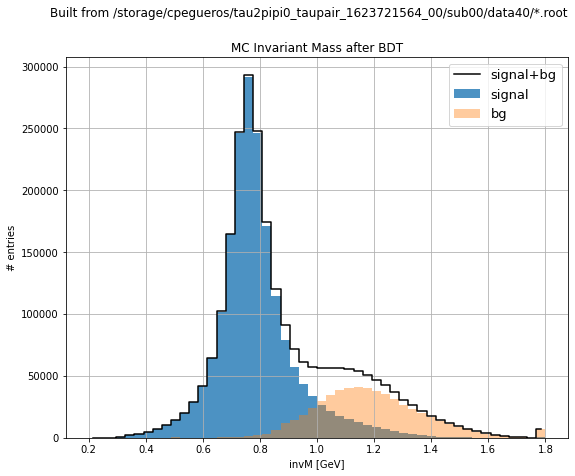

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(9, 7))
fig.suptitle(f"Built from {config['data']['files']}")

# Plot the histograms of how signal and bg is distributed after BDT
ax_eval = axs
ax_eval.bar(signal.axes[0].centers, signal.view(), width=signal.axes[0].widths, label="signal", alpha=0.8)
ax_eval.bar(background.axes[0].centers, background.view(), width=background.axes[0].widths, label="bg", alpha=0.4)
composite = signal + background
ax_eval.step(composite.axes[0].centers, composite.view(), color="black", label="signal+bg", where="mid")
ax_eval.grid()
ax_eval.set_title("MC Invariant Mass after BDT")
ax_eval.set_xlabel("invM [GeV]")
ax_eval.set_ylabel("# entries")
_ = ax_eval.legend(prop={"size": 13})

## Unfolding
Perform the unfolding

In [35]:
# Unfolding libraries
from unfolders.unfolder import Unfolder
from utils.stats import compute_numpy_covariance_matrix
from unfolders.annealing import (
    SimulatedAnnealingBackend,
    SimulatedQuantumAnnealingBackend,
)
from unfolders.svd import SVDBackend

config = get_config(is_jaguar=False)

Loading configuration to run in local. No data will be available.


In [36]:
# First, load the histograms
with open(config["histograms_path"], 'rb') as output:
    temp = pickle.load(output)
    data_hist = temp["signal"]
    background_hist = temp["background"]
    # convert to numpy array
    signal, signal_bins = data_hist.to_numpy()
    background, background_bins = background_hist.to_numpy()

# And load the response matrix
with open(config["response_matrix_path"], 'rb') as output:
    response_data = pickle.load(output)
    # transform histograms to numpy arrays
    truth, truth_bins = response_data["truth"].to_numpy()
    reco, reco_bins = response_data["reco"].to_numpy()
    R, R_bins_x, R_bins_y = response_data["R"].to_numpy()

In [39]:
# try unfolding the signal and the bg
nbins, rmin, rmax = config["hist"]["nbins"], config["hist"]["rmin"], config["hist"]["rmax"]

# unfold the signal
unfolder = Unfolder(signal, compute_numpy_covariance_matrix(signal), truth, reco, R)
bad_signal_annealing_result = unfolder.unfold(SimulatedAnnealingBackend(4, 100, weight_regularization=0.7, encoder_scale=0.5, encoder_use_alpha=True))
signal_annealing_result = unfolder.unfold(SimulatedAnnealingBackend(4, 100, weight_regularization=0.7, encoder_scale=1, encoder_use_alpha=False))
signal_svd_result = unfolder.unfold(SVDBackend(13, rmin, rmax))

# unfold the background
unfolder = Unfolder(background, compute_numpy_covariance_matrix(background), truth, reco, R)
bad_bg_annealing_result = unfolder.unfold(SimulatedAnnealingBackend(4, 100, weight_regularization=0.7, encoder_scale=0.5, encoder_use_alpha=True))
bg_annealing_result = unfolder.unfold(SimulatedAnnealingBackend(10, 100, weight_regularization=0.7, encoder_scale=4, encoder_use_alpha=False))
bg_svd_result = unfolder.unfold(SVDBackend(13, rmin, rmax))

/home/peguerosdc/development/thesis/unfolders/annealing/backend.py:233: RuntimeWarning: invalid value encountered in true_divide
  R_probabilities = np.where(xini > 0, np.divide(R, xini), 0)


num reads: 100
num reads: 100
num reads: 100
num reads: 100


Info in <TSVDUnfold::Unfold>: Unfolding param: 13
Info in <TSVDUnfold::Unfold>: Curvature of weight distribution: 0.015560
Info in <TSVDUnfold::Unfold>: Unfolding param: 13
Info in <TSVDUnfold::Unfold>: Curvature of weight distribution: 0.131815


Text(0, 0.5, '# entries')

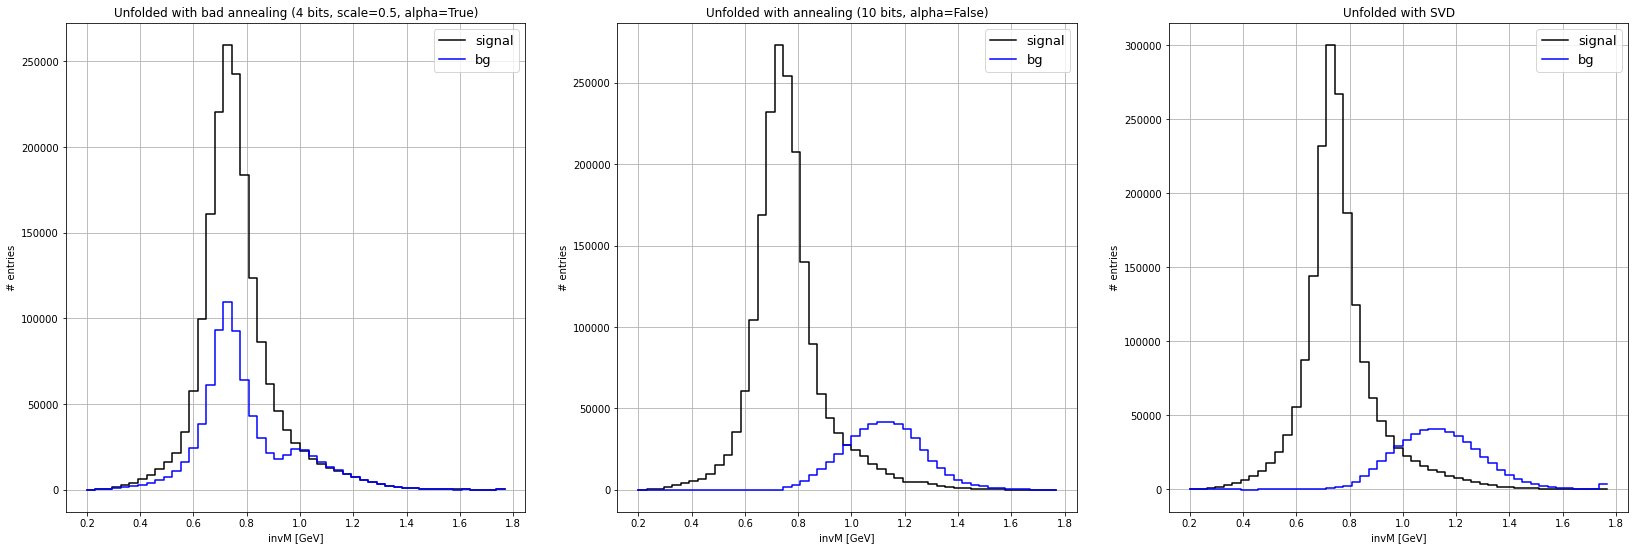

In [40]:
# Plot the result
axis = truth_bins[:-1]
fig, axs = plt.subplots(1, 3, figsize=(28, 9))

# Plot the signal and background unfolded with a bad annealing
bad_ann_axs = axs[0]
bad_ann_axs.step(
    axis, bad_signal_annealing_result.solution,
    color="black", label="signal",
)
bad_ann_axs.step(
    axis, bad_bg_annealing_result.solution,
    color="blue", label="bg",
)
bad_ann_axs.legend(prop={"size": 13})
bad_ann_axs.grid()
bad_ann_axs.set_title("Unfolded with bad annealing (4 bits, scale=0.5, alpha=True)")
bad_ann_axs.set_xlabel("invM [GeV]")
bad_ann_axs.set_ylabel("# entries")


# Plot the signal and background unfolded with a good annealing
good_ann_axs = axs[1]
good_ann_axs.step(
    axis, signal_annealing_result.solution,
    color="black", label="signal",
)
good_ann_axs.step(
    axis, bg_annealing_result.solution,
    color="blue", label="bg",
)
good_ann_axs.legend(prop={"size": 13})
good_ann_axs.grid()
good_ann_axs.set_title("Unfolded with annealing (10 bits, alpha=False)")
good_ann_axs.set_xlabel("invM [GeV]")
good_ann_axs.set_ylabel("# entries")

# Plot the signal and background unfolded with SVD
svd_axs = axs[2]
svd_axs.step(
    axis, signal_svd_result.solution,
    color="black", label="signal",
)
svd_axs.step(
    axis, bg_svd_result.solution,
    color="blue", label="bg",
)
svd_axs.legend(prop={"size": 13})
svd_axs.grid()
svd_axs.set_title("Unfolded with SVD")
svd_axs.set_xlabel("invM [GeV]")
svd_axs.set_ylabel("# entries")